<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main()</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [18]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [23]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()
        
    def Combine(self):
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
        descriptors_center_atoms = self.descriptors[atom_ids]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        #--- train-test split
        X = np.c_[self.descriptors]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,

                     } 

        #--- train
        mlp = MLPClassifier(random_state=random_state)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )


        #--- confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)

        #-----------------------
        #--- parameter grid
        #-----------------------
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,
                     } 

        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    #layers.Dense(1000), #activation="relu"),
                    layers.Dense(ndime) #, activation="relu")
                    ])
                optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose)#, batch_size=128)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetwork(X_train, y_train, X_test, y_test )
            

        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        #--- plot predictions
        y_pred       = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
            utl.PltErr(y_test[:,idime],y_pred[:,idime],
                       attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
        
        #--- save in ovito
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('test.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_test,y_pred],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="val_loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                     callbacks=callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )

        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #
#         pdb.set_trace()
        #------------------------------
        #--- The network architecture
        #------------------------------
        model     = keras.Sequential([
            layers.Dense(self.hidden_layer_size, activation="relu"),
#             layers.Dense(self.hidden_layer_size), #activation="relu"),
            layers.Dense(2, activation="softmax")
            ])
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

        model.compile( optimizer="rmsprop",
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"])


        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train 
        X_test_reshaped  =  X_test
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                     callbacks=callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )        


        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#                                                    monitor="val_loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]


        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        !mkdir png
        utl.PltErr(range(len(loss)), loss,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss_classification.png',
                  )

#         pdb.set_trace()
        #--- confusion matrix
        cm = confusion_matrix(y_test, model.predict_classes(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)
        np.savetxt('png/confusion.txt',np.c_[cm])
    

    
    def PrintDensityMap(self, atomIndx, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData.iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.positions.T,self.descriptors[atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())


## main()

dim(y)= (1366, 1)
X.shape:= (1366, 1331)
Train on 1024 samples, validate on 342 samples
Epoch 1/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.9143 - mean_squared_error: 0.4913 - val_loss: 1.0102 - val_mean_squared_error: 0.4993
Epoch 2/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0314 - mean_squared_error: 0.4999 - val_loss: 0.4396 - val_mean_squared_error: 0.5000
Epoch 3/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 3.0721e-06 - mean_squared_error: 0.5000 - val_loss: 0.4372 - val_mean_squared_error: 0.5000
Epoch 4/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 2.7355e-06 - mean_squared_error: 0.5000 - val_loss: 0.4298 - val_mean_squared_error: 0.5000
Epoch 5/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 1.8366e-06 - mean_squared_error: 0.5000 - val_loss: 0.4214 - val_mean_squared_error: 0.5000
Epoch 6/100
1024/1024 [==============================] - 2s 2ms/s

1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8441 - val_mean_squared_error: 0.5000
Epoch 49/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8461 - val_mean_squared_error: 0.5000
Epoch 50/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8481 - val_mean_squared_error: 0.5000
Epoch 51/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8500 - val_mean_squared_error: 0.5000
Epoch 52/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8518 - val_mean_squared_error: 0.5000
Epoch 53/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.8537 - val_mean_squ

Epoch 96/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.9101 - val_mean_squared_error: 0.5000
Epoch 97/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.9111 - val_mean_squared_error: 0.5000
Epoch 98/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.9121 - val_mean_squared_error: 0.5000
Epoch 99/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.9130 - val_mean_squared_error: 0.5000
Epoch 100/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 0.9140 - val_mean_squared_error: 0.5000
mkdir: cannot create directory ‘best_model’: File exists
mkdir: cannot create directory ‘png’: File exists


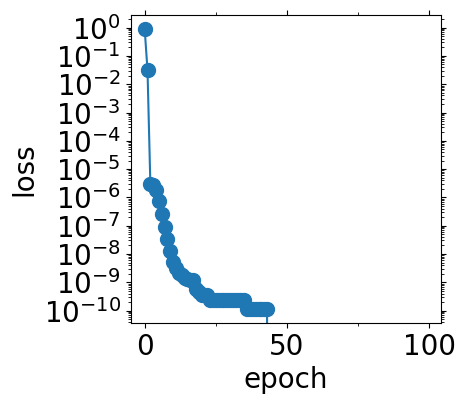

cm= [[340   0]
 [  1   1]]


In [24]:
 def main():
        
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
                        n_iter_no_change   = eval(confParser['neural net']['n_iter_no_change']),
                        tol                = eval(confParser['neural net']['tol']),
                        max_iter           = eval(confParser['neural net']['max_iter']),
                        alpha              = eval(confParser['neural net']['alpha']),
                        hidden_layer_size  = eval(confParser['neural net']['hidden_layer_size']),
                        fully_connected    = eval(confParser['neural net']['fully_connected']),
                        implementation     = eval(confParser['neural net']['implementation']),
                        cnn                = eval(confParser['neural net']['cnn']),
                        n_channels         = eval(confParser['neural net']['n_channels']),
                        kernel_size        = eval(confParser['neural net']['kernel_size']),
                        activation         = eval(confParser['neural net']['activation']),
                        number_hidden_layers = eval(confParser['neural net']['number_hidden_layers']),
                        verbose            = True 
                    )
    nn.Parse( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net']['nruns']))
    nn.Combine()
#     tmp = nn.df_combined.set_index('id')
#    display(nn.perAtomData.iloc[:13])
#    nn.PrintDensityMap(6,'density6.xyz')
    #    
#    nn.PCA()
#    nn.Spectra()
#    nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
    nn.ConvNetworkClassifier( np.c_[ nn.perAtomData.defect_label ].astype( int ) )
    
    return nn
    #--- filter data
    train_type = int(eval(confParser['neural net']['train_type']))
    filtr      = {
                     0: nn.perAtomData.defect_label == 1.0, #--- only defetive atoms
                     1: np.ones(len(nn.perAtomData),dtype=bool), #--- every atom
                    }[train_type]
    stratify   = {
                    0:None,
                    1:np.c_[nn.perAtomData.defect_label].astype(int), #--- ensure same ratio in test and training
                    }[train_type]


    
    #--- train
    nn.TrainRegressor(  stratify=stratify,
                        y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                        printOvito = True,
                        filtr=filtr,
                     )
    return nn

data = main()

### Plot

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    
    
    script = 'postproc.py test_ncbj_slurm.py'.split()[1]
    number_hidden_layers  = dict(zip(range(4),[1,2,3]))
    n_channels  = dict(zip(range(4),[8,16,32,64]))
    activations = dict(zip(range(20),['linear']))
    runs = [1]
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
        if number_hidden_layer != 3:
            continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 4:
#                 continue
            for key_a in activations:
                activation = activations[key_a]

        #---	
                path = 'neuralNet/ni/keras/20x20/cnn/layer%s/channel%s/activation%s'%(key_n,key_c,key_a) #--- change job name
                for irun in runs:
                    data = np.loadtxt('%s/Run%s/png/loss.txt'%(path,irun))

                    epoch = data[:,0]
                    loss = data[:,1]
                    val_loss = data[:,2]

                    utl.PltErr(epoch, loss,#val_loss,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1000,
                            label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                               Plot=False,
                               ax=ax,
                               )
                count += 1
    ax = utl.PltErr(None, None,
                       yscale='log',xscale='log',
                       xstr='epoch',ystr='training loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

## test example: 2d

In [ ]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

### fully connected in sklearn

In [ ]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
# #                    verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=10000,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [ ]:
# mlp.best_loss_, mlp.loss_

In [ ]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# ux,uy

In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [ ]:
# data.Spectra(nrows=100)

In [ ]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [ ]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [ ]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [ ]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [ ]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# (ux,uy), y_test[0]